In [1]:

import numpy as np
import cv2
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from patchify import patchify

2023-04-17 02:55:39.995341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 02:55:40.203816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/venv/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-17 02:55:40.203844: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-17 02:55:41.448340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror

In [2]:
model = tf.keras.models.load_model('/work/Cavity_detection/models/DCNN3/best_model.h5')
img_path = '/work/Cavity_detection/data/interim/caries/Image_584_RODRIGUEZ-MORENO-MARTHA-CECILIA_Intraoral_JPG.rf.31b5f660874bb6e27301bbde7243fa3a.jpg'

2023-04-17 02:55:44.337828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/venv/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-17 02:55:44.337862: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-17 02:55:44.337881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-8f63fdc3-7b28-4cc7-8735-09f23d070fd3): /proc/driver/nvidia/version does not exist
2023-04-17 02:55:44.338139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow 

In [3]:
img_path = '/work/test.jpg'

In [4]:
img_path = '/work/Cavity_detection/data/interim/caries/Image_584_RODRIGUEZ-MORENO-MARTHA-CECILIA_Intraoral_JPG.rf.31b5f660874bb6e27301bbde7243fa3a.jpg'

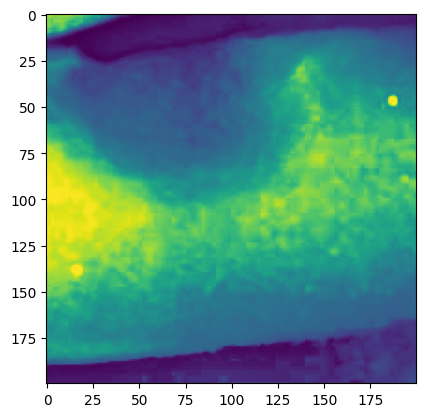

In [5]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit =10.0, tileGridSize=(8,8)) # Parameters used in original paper
test = clahe.apply(img)
test = test [300:500, 500:700]
cv2.imwrite('test.jpg', test)
# plt.imshow(test)

image = cv2.imread('/work/test.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image)

In [6]:
def predict_regions(image, threshold=0.5, region_height=100, region_width=100):
    # clahe and normalization
    clahe = cv2.createCLAHE(clipLimit =10.0, tileGridSize=(8,8)) # Parameters used in original paper
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # img = clahe.apply(img)/255.0

    # add gauss padding if necesary (to have regions of the complete image)
    h, w = img.shape
    pad_h = (region_height - h % region_height) % region_height
    pad_w = (region_width - w % region_width) % region_width
    
    if (pad_h > 0 or pad_w > 0):
        noise = np.zeros((h + pad_h, w + pad_w))
        # noise = np.random.normal(np.mean(img), np.std(img), (h + pad_h, w + pad_w))
        noise[:h, :w] = img
        img = noise

    plt.imshow(img)

    # extract regions from image (no overlap)
    regions = patchify(img, (region_height, region_width), step=100)
    
    # reshape regions array to model input shape
    regions_shape = regions.shape  # (h, w, 100, 100)
    regions_reshaped = np.reshape(regions, (regions_shape[0]*regions_shape[1],) + regions_shape[2:] + (1,))  # (h x w, 100, 100, 1)

    # Make predictions
    predictions = model.predict(regions_reshaped)


    # binary input using threshold
    predictions_binary = (predictions > threshold).astype(np.uint8)  # (h x w, 1)
    predictions_2d = np.reshape(predictions_binary, (regions_shape[0], regions_shape[1]))  # (h, w)

    return predictions_2d

    
    


5/5 [==============================] - 1s 79ms/step


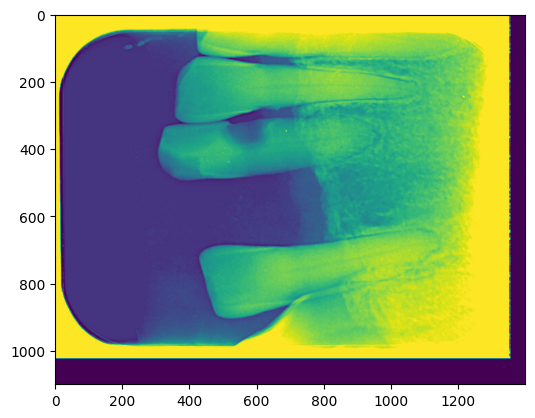

In [7]:
result = predict_regions(img_path)

In [10]:
def draw_bounding_boxes(image_path, predictions_2d, region_height=100, region_width=100):
    image = cv2.imread(image_path)/255.0
    # Get image height and width
    img_h, img_w = image.shape[:2]
    

    # Initialize bounding boxes list
    boxes = []
    
    # Iterate through each region in the prediction matrix
    for i in range(predictions_2d.shape[0]):
        for j in range(predictions_2d.shape[1]):
            if predictions_2d[i][j] == 1:
                # Calculate region coordinates in the original image
                x = j*region_width
                y = i*region_height
                x2 = x+region_width
                y2 = y+region_height
                
                # Ensure region stays within image bounds
                x = max(0, x)
                y = max(0, y)
                x2 = min(img_w, x2)
                y2 = min(img_h, y2)
                
                # Check if current box is adjacent to any previous boxes
                for box in boxes:
                    if x >= box[0] and x <= box[2] and y >= box[1] and y <= box[3]:
                        # Extend the box to include the current region
                        box[0] = min(box[0], x)
                        box[1] = min(box[1], y)
                        box[2] = max(box[2], x2)
                        box[3] = max(box[3], y2)
                        break
                else:
                    # Add new bounding box for current region
                    boxes.append([x, y, x2, y2])
                # boxes.append([x, y, x2, y2])
    
    # Draw bounding boxes on the original image
    for box in boxes:
        # print(f'{box[0]}, {box[1]}')
        # cv2.putText(image, f'{box[0]}, {box[1]}', (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    
    return image


5/5 [==============================] - 0s 78ms/step
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


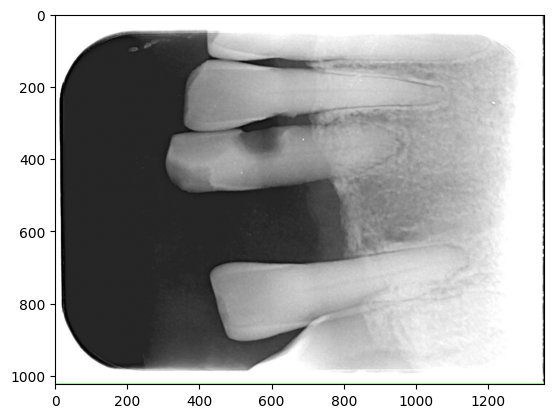

In [13]:
result = draw_bounding_boxes(img_path, predict_regions(img_path, threshold=0.5))
plt.imshow(result)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f63fdc3-7b28-4cc7-8735-09f23d070fd3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>